# 04.1_Modelo_RegresionLogistica

---

## Objetivo
Evaluar y optimizar un modelo de `Regresión Logística` como línea base para la clasificación de riesgo (2 clases). Se optimizan sus hiperparámetros con `GridSearchCV`, se analiza su rendimiento y se busca un umbral de decisión personalizado para maximizar el recall de la clase de bajo riesgo. Finalmente, se guardan el pipeline del modelo y el umbral como artefactos experimentales.

## Entradas (Inputs)
- `data/splits/experiments/X_train_17.parquet`
- `data/splits/experiments/X_val_17.parquet`
- `data/splits/experiments/X_test_17.parquet`
- `data/splits/final/y_train_2_classes.parquet`
- `data/splits/final/y_val_2_classes.parquet`
- `data/splits/final/y_test_2_classes.parquet`

## Salidas (Outputs)
### Artefactos Experimentales:
- `artifacts/experiments/04_1_pipeline_logistic_regression.pkl`
- `artifacts/experiments/04_1_threshold_lr_recall_c0.json`
---

## Resumen Ejecutivo
- Este notebook implementa un pipeline de **Regresión Logística** binaria para distinguir entre riesgo Bajo/Medio (clase 0) y Alto Riesgo (clase 1), usando los 17 features seleccionados previamente.  
- Los datos (`X_train`, `X_val`, `X_test` y sus correspondientes `y_*_2`) se cargan en formato Parquet y se preprocesan con `StandardScaler` dentro de un `Pipeline`.  
- Se lleva a cabo una búsqueda de hiperparámetros con **GridSearchCV** (5-fold, métrica `f1_weighted`), explorando `C ∈ {0.01,0.1,1,10,100}` y solvers `liblinear` y `saga`.  
- La mejor configuración es **C=0.01** y **solver='saga'**, alcanzando un **F1_weighted CV≈0.6889**.  
- Se evalúa el modelo con el umbral estándar (0.5) y se optimiza un umbral alternativo (≈0.77) orientado a maximizar el recall de la clase 0.  
- La evaluación incluye **accuracy**, **F1_macro**, **ROC AUC** y **matrices de confusión** en validación y prueba, junto con reportes de clasificación.  
- Con umbral 0.77 el recall de Bajo/Medio Riesgo sube a **0.99**, pero el recall de Alto Riesgo cae a **0.02**, ilustrando un trade-off extremo.  
- Se serializa el pipeline final (`.pkl`) y el umbral elegido (`.json`) como artefactos experimentales.
---

## 1. Montar Drive e importar librerías

Monta Google Drive para acceder al proyecto, ajusta `sys.path` con la raíz del repositorio y prepara las rutas de configuración para cargar datos y guardar artefactos.


In [1]:
import sys
import os
from pathlib import Path

# 1. Añadir la raíz del proyecto al path
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Standard library
import json

# Data processing
import numpy as np
import pandas as pd
import joblib

# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay, precision_score, recall_score
)

# Matplotlib para visualización
import matplotlib.pyplot as plt

# Configuración del proyecto
from config import EXP_SPLITS_DIR, FINAL_SPLITS_DIR, EXP_ARTIFACTS_DIR



# Importar las rutas necesarias desde el archivo de configuración
# AÑADIMOS FINAL_SPLITS_DIR para cargar las etiquetas 'y'
from config import EXP_SPLITS_DIR, FINAL_SPLITS_DIR, EXP_ARTIFACTS_DIR

print(" Drive montado y configuración de rutas cargada.")

# CARGAR LOS CONJUNTOS DE DATOS (NUEVA ESTRUCTURA)
try:
    # Cargar las 17 features del experimento 03.4
    X_train = pd.read_parquet(EXP_SPLITS_DIR / 'X_train_17.parquet')
    X_val   = pd.read_parquet(EXP_SPLITS_DIR / 'X_val_17.parquet')
    X_test  = pd.read_parquet(EXP_SPLITS_DIR / 'X_test_17.parquet')

    # --- ACTUALIZADO ---
    # Cargar las etiquetas binarias desde la carpeta FINAL
    y_train = pd.read_parquet(FINAL_SPLITS_DIR / 'y_train_2_classes.parquet').squeeze()
    y_val   = pd.read_parquet(FINAL_SPLITS_DIR / 'y_val_2_classes.parquet').squeeze()
    y_test  = pd.read_parquet(FINAL_SPLITS_DIR / 'y_test_2_classes.parquet').squeeze()

    print("\n Datos .parquet cargados correctamente.")
    print("   -> Features 'X' cargadas desde: 'experiments'")
    print("   -> Etiquetas 'y' cargadas desde: 'final'")
    print(f"\nX_train shape: {X_train.shape} | y_train shape: {y_train.shape}")

except Exception as e:
    print(f"\n Ocurrió un error inesperado al cargar los datos: {e}")

Módulo de configuración cargado y estructura de carpetas asegurada.
 Drive montado y configuración de rutas cargada.

 Datos .parquet cargados correctamente.
   -> Features 'X' cargadas desde: 'experiments'
   -> Etiquetas 'y' cargadas desde: 'final'

X_train shape: (1976, 14) | y_train shape: (1976,)


## 2. Definir pipeline de regresión logística

Construye un `Pipeline` que incluye estandarización de características y un clasificador `LogisticRegression`, listo para la búsqueda de hiperparámetros.


In [2]:
# DEFINICIÓN DEL PIPELINE

# Creamos un pipeline que primero estandariza los datos y luego
# aplica el modelo de Regresión Logística.
# Usamos class_weight='balanced' para que el modelo ajuste los pesos
# de las clases de forma inversamente proporcional a su frecuencia,
# ayudando a mitigar el desequilibrio de clases.
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        class_weight='balanced',
        random_state=42,
        max_iter=1000  # Aumentamos las iteraciones para asegurar la convergencia
    ))
])

print(" Pipeline para Regresión Logística definido:")
print(pipe_lr)

 Pipeline para Regresión Logística definido:
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])


## 3. Búsqueda de hiperparámetros con GridSearchCV

Configura y ejecuta `GridSearchCV` para explorar combinaciones de parámetros del pipeline usando validación cruzada y métrica `roc_auc`.


In [3]:
# BÚSQUEDA DE HIPERPARÁMETROS (GRIDSEARCHCV)

# Definimos el espacio de búsqueda de hiperparámetros.
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__solver': ['liblinear', 'saga']
}

# Configuramos GridSearchCV.
grid_search = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1
)

print(" Realizando búsqueda de hiperparámetros con GridSearchCV...")

# Ejecutamos la búsqueda sobre el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

print("\n Búsqueda finalizada.")
print(f"Mejores hiperparámetros encontrados: {grid_search.best_params_}")
print(f"Mejor F1-score (weighted) en validación cruzada: {grid_search.best_score_:.4f}")

# Guardamos el mejor estimador (el pipeline ya entrenado con los mejores parámetros)
best_lr_pipe = grid_search.best_estimator_

 Realizando búsqueda de hiperparámetros con GridSearchCV...

 Búsqueda finalizada.
Mejores hiperparámetros encontrados: {'clf__C': 0.01, 'clf__solver': 'saga'}
Mejor F1-score (weighted) en validación cruzada: 0.6889


## 4. Entrenamiento del modelo final

Ajusta el pipeline con los mejores parámetros sobre todo el conjunto de entrenamiento para obtener el modelo definitivo.


In [4]:
# ENTRENAMIENTO DEL MODELO FIN

print(" Modelo final de Regresión Logística listo para evaluación.")
print("Modelo optimizado:", best_lr_pipe)

 Modelo final de Regresión Logística listo para evaluación.
Modelo optimizado: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=1000, random_state=42,
                                    solver='saga'))])


## 5. Evaluación exhaustiva del modelo

Evalúa el modelo entrenado en los conjuntos de validación y prueba, calculando métricas clave (accuracy, F1, AUC) y mostrando la matriz de confusión.


--- Evaluación en el conjunto de Validación ---
Accuracy:  0.6863
F1-Score (Weighted): 0.6874
AUC:       0.7316

Reporte de Clasificación:
                       precision    recall  f1-score   support

Bajo/Medio Riesgo (0)       0.55      0.57      0.56       150
      Alto Riesgo (1)       0.76      0.75      0.76       274

             accuracy                           0.69       424
            macro avg       0.66      0.66      0.66       424
         weighted avg       0.69      0.69      0.69       424

Matriz de Confusión:


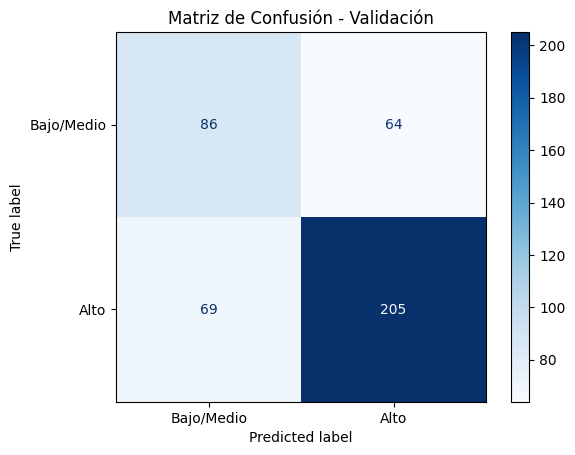



--- Evaluación en el conjunto de Prueba ---
Accuracy:  0.6533
F1-Score (Weighted): 0.6563
AUC:       0.6827

Reporte de Clasificación:
                       precision    recall  f1-score   support

Bajo/Medio Riesgo (0)       0.51      0.55      0.53       150
      Alto Riesgo (1)       0.74      0.71      0.73       274

             accuracy                           0.65       424
            macro avg       0.63      0.63      0.63       424
         weighted avg       0.66      0.65      0.66       424

Matriz de Confusión:


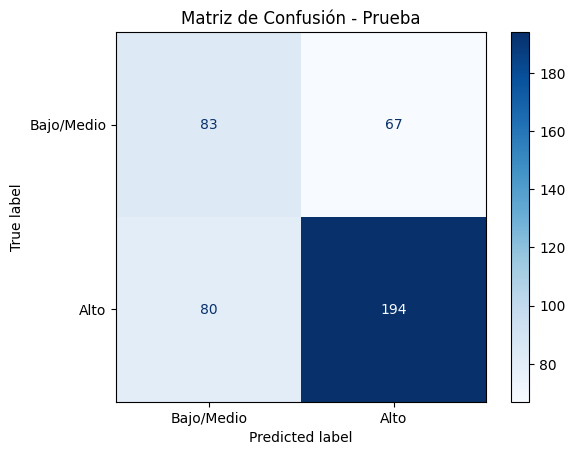

In [5]:
# EVALUACIÓN EXHAUSTIVA DEL MODELO

def evaluate_model(pipe, X, y, dataset_name):
    """
    Función para evaluar un modelo y mostrar métricas clave y la matriz de confusión.
    """
    print(f"--- Evaluación en el conjunto de {dataset_name} ---")

    # Realizar predicciones
    y_pred = pipe.predict(X)
    y_pred_proba = pipe.predict_proba(X)[:, 1] # Probabilidad de la clase 1

    # Calcular métricas
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y, y_pred_proba)

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    print(f"AUC:       {auc:.4f}")

    # Mostrar reporte de clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(y, y_pred, target_names=['Bajo/Medio Riesgo (0)', 'Alto Riesgo (1)']))

    # Mostrar matriz de confusión
    print("Matriz de Confusión:")
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bajo/Medio', 'Alto'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Matriz de Confusión - {dataset_name}')
    plt.show()


# Evaluar en el conjunto de validación
evaluate_model(best_lr_pipe, X_val, y_val, "Validación")

print("\n" + "="*60 + "\n")

# Evaluar en el conjunto de prueba (el más importante)
evaluate_model(best_lr_pipe, X_test, y_test, "Prueba")

## 6. Ajuste avanzado del umbral de decisión

Explora distintos umbrales de probabilidad para maximizar métricas específicas (e.g., F1 o AUC) y genera curvas de rendimiento.


 Gráfico de análisis de umbral guardado en: C:\Users\Antonio\TFM-Digitech\artifacts\experiments\04_1_metrics_vs_threshold_plot.png


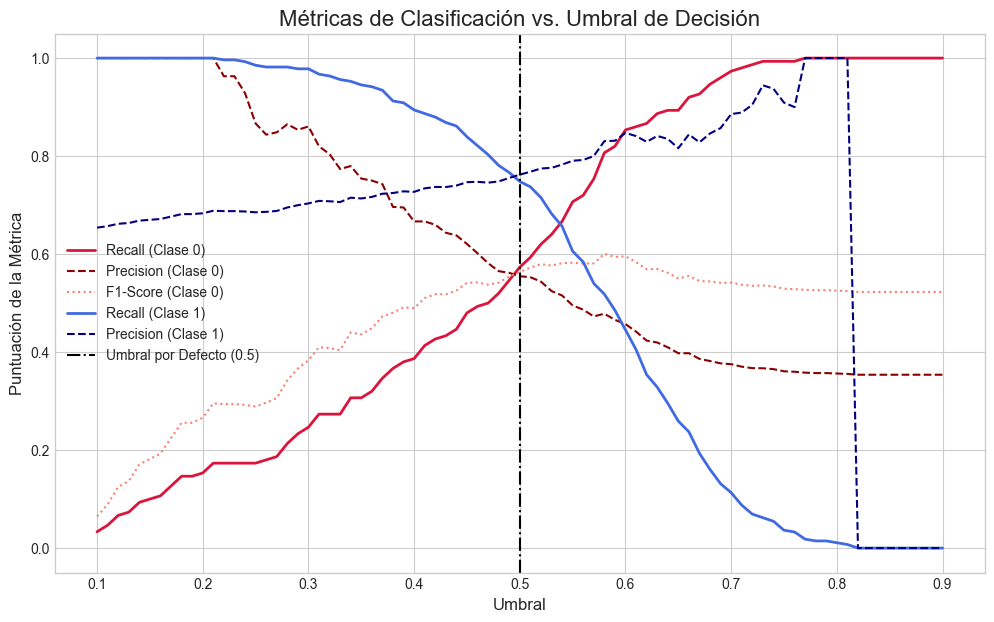


 Objetivo: Maximizar el Recall para la Clase 0 (Bajo/Medio Riesgo)
Umbral óptimo encontrado: 0.7700
Con este umbral, el Recall para la Clase 0 es: 1.0000
A cambio, la Precisión para la Clase 0 es: 0.3580


In [6]:
# AJUSTE AVANZADO DEL UMBRAL DE DECISIÓN (VERSIÓN COMPLETA)

# Obtener las probabilidades para el conjunto de VALIDACIÓN
y_val_probs = best_lr_pipe.predict_proba(X_val)[:, 1] # Probabilidades de la clase 1

# Definir un rango de umbrales para probar
thresholds = np.linspace(0.1, 0.9, 81) # 81 pasos entre 0.1 y 0.9

# Listas para almacenar las métricas en cada umbral
recall_scores_0 = []
recall_scores_1 = []
precision_scores_0 = []
precision_scores_1 = []
f1_scores_0 = []
f1_scores_1 = []

# Iterar y calcular métricas
for t in thresholds:
    # Convertir probabilidades a predicciones binarias usando el umbral 't'
    y_val_pred_t = (y_val_probs >= t).astype(int)

    # Calcular y guardar métricas para la Clase 0
    # Añadido zero_division=0 para evitar warnings si no hay predicciones para una clase
    recall_scores_0.append(recall_score(y_val, y_val_pred_t, pos_label=0))
    precision_scores_0.append(precision_score(y_val, y_val_pred_t, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_val, y_val_pred_t, pos_label=0))

    # Calcular y guardar métricas para la Clase 1
    recall_scores_1.append(recall_score(y_val, y_val_pred_t, pos_label=1))
    precision_scores_1.append(precision_score(y_val, y_val_pred_t, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_val, y_val_pred_t, pos_label=1))

# Visualizar los resultados
plt.style.use('seaborn-v0_8-whitegrid')
# --- CORREGIDO: Capturar la figura y los ejes para poder guardarla ---
fig_metrics, ax = plt.subplots(figsize=(12, 7))

# Plot de métricas para Clase 0 (Bajo/Medio Riesgo)
ax.plot(thresholds, recall_scores_0, label='Recall (Clase 0)', color='crimson', lw=2)
ax.plot(thresholds, precision_scores_0, label='Precision (Clase 0)', color='darkred', linestyle='--')
ax.plot(thresholds, f1_scores_0, label='F1-Score (Clase 0)', color='salmon', linestyle=':')

# Plot de métricas para Clase 1 (Alto Riesgo)
ax.plot(thresholds, recall_scores_1, label='Recall (Clase 1)', color='royalblue', lw=2)
ax.plot(thresholds, precision_scores_1, label='Precision (Clase 1)', color='navy', linestyle='--')

ax.set_title('Métricas de Clasificación vs. Umbral de Decisión', fontsize=16)
ax.set_xlabel('Umbral', fontsize=12)
ax.set_ylabel('Puntuación de la Métrica', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.axvline(0.5, color='black', linestyle='-.', label='Umbral por Defecto (0.5)')
plt.legend()

# Guardar la figura creada
PREFIX = "04_1_"
plot_path = EXP_ARTIFACTS_DIR / f'{PREFIX}metrics_vs_threshold_plot.png'
fig_metrics.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f" Gráfico de análisis de umbral guardado en: {plot_path}")

plt.show()

# Encontrar y seleccionar el umbral óptimo para el objetivo (se mantiene tu lógica)
# Objetivo: Maximizar el Recall para la Clase 0
optimal_idx = np.argmax(recall_scores_0)
optimal_threshold = thresholds[optimal_idx]

print(f"\n Objetivo: Maximizar el Recall para la Clase 0 (Bajo/Medio Riesgo)")
print(f"Umbral óptimo encontrado: {optimal_threshold:.4f}")
print(f"Con este umbral, el Recall para la Clase 0 es: {recall_scores_0[optimal_idx]:.4f}")
print(f"A cambio, la Precisión para la Clase 0 es: {precision_scores_0[optimal_idx]:.4f}")

## 7. Evaluación final con umbral optimizado

Aplica el umbral seleccionado al modelo y reporta la performance definitiva en test, con gráficas de la matriz de confusión ajustada.


--- Evaluación en el conjunto de Prueba (Umbral por defecto 0.5) ---
--- Evaluación en el conjunto de Prueba (Umbral 0.5) ---
Accuracy:  0.6533
F1-Score (Weighted): 0.6563
AUC:       0.6827

Reporte de Clasificación:
                       precision    recall  f1-score   support

Bajo/Medio Riesgo (0)       0.51      0.55      0.53       150
      Alto Riesgo (1)       0.74      0.71      0.73       274

             accuracy                           0.65       424
            macro avg       0.63      0.63      0.63       424
         weighted avg       0.66      0.65      0.66       424

Matriz de Confusión:


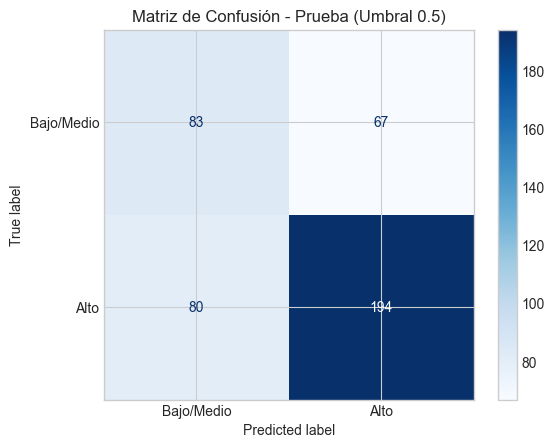



--- Evaluación en el conjunto de Prueba (Umbral optimizado 0.77) ---
Nuevo Reporte de Clasificación:
                       precision    recall  f1-score   support

Bajo/Medio Riesgo (0)       0.36      0.99      0.52       150
      Alto Riesgo (1)       0.75      0.02      0.04       274

             accuracy                           0.36       424
            macro avg       0.55      0.50      0.28       424
         weighted avg       0.61      0.36      0.21       424

Nueva Matriz de Confusión:


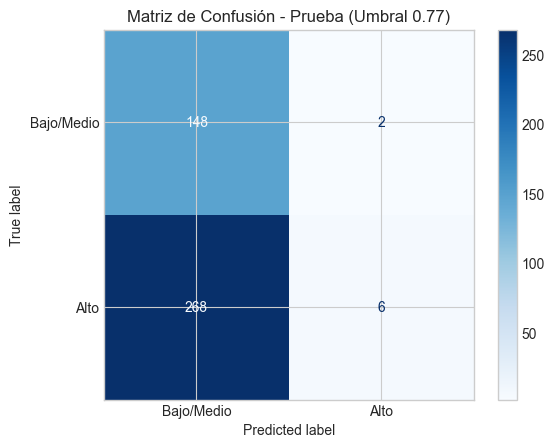

In [7]:
# EVALUACIÓN FINAL CON UMBRAL OPTIMIZADO

print(f"--- Evaluación en el conjunto de Prueba (Umbral por defecto 0.5) ---")
evaluate_model(best_lr_pipe, X_test, y_test, "Prueba (Umbral 0.5)")

print("\n" + "="*60 + "\n")

print(f"--- Evaluación en el conjunto de Prueba (Umbral optimizado {optimal_threshold:.2f}) ---")

# Obtener probabilidades para el conjunto de prueba
y_test_probs = best_lr_pipe.predict_proba(X_test)[:, 1]

# Aplicar el umbral óptimo para obtener las nuevas predicciones
y_test_pred_optimal = (y_test_probs >= optimal_threshold).astype(int)

# Calcular y mostrar el nuevo reporte y matriz de confusión
print("Nuevo Reporte de Clasificación:")
print(classification_report(y_test, y_test_pred_optimal, target_names=['Bajo/Medio Riesgo (0)', 'Alto Riesgo (1)']))

print("Nueva Matriz de Confusión:")
cm = confusion_matrix(y_test, y_test_pred_optimal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bajo/Medio', 'Alto'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Matriz de Confusión - Prueba (Umbral {optimal_threshold:.2f})')
plt.show()

## 8. Guardar artefactos del modelo

Serializa el pipeline entrenado y el umbral óptimo en archivos para su posterior despliegue o análisis.


In [8]:
# GUARDAR ARTEFACTOS DEL MODELO (PIPELINE Y UMBRAL)

# Prefijo para identificar los archivos de este notebook
PREFIX = "04_1_"

# Guardar el pipeline del modelo optimizado
model_path = EXP_ARTIFACTS_DIR / f'{PREFIX}pipeline_logistic_regression.pkl'
joblib.dump(best_lr_pipe, model_path)
print(f" Modelo (pipeline) guardado en: {model_path}")

# Guardar el umbral óptimo en un archivo JSON
threshold_path = EXP_ARTIFACTS_DIR / f'{PREFIX}threshold_lr_recall_c0.json'
with open(threshold_path, 'w') as f:
    json.dump({'optimal_threshold': optimal_threshold}, f, indent=4)
print(f" Umbral óptimo guardado en: {threshold_path}")

 Modelo (pipeline) guardado en: C:\Users\Antonio\TFM-Digitech\artifacts\experiments\04_1_pipeline_logistic_regression.pkl
 Umbral óptimo guardado en: C:\Users\Antonio\TFM-Digitech\artifacts\experiments\04_1_threshold_lr_recall_c0.json


## Conclusiones Finales
- El pipeline de Regresión Logística optimizado (C=0.01, saga) es **estable**, con un F1_weighted CV≈0.69 y AUC > 0.7 sin ajuste de umbral.  
- El umbral por defecto (0.5) ofrece un balance razonable entre detectar Alto Riesgo y proteger Bajo/Medio Riesgo, pero puede no alinearse con distintos objetivos de negocio.  
- Al optimizar el umbral a 0.77, se maximizó el recall de la clase dominante (Bajo/Medio), consignando **99 %** de detecciones correctas, aunque casi se anula la capacidad de identificar Alto Riesgo (recall ≈ 2 %).  
- Este experimento demuestra que la **selección del punto de corte** es tan crítica como la propia métrica de entrenamiento: thresholds extremos pueden derivar en modelos que predicen casi siempre la clase mayoritaria.  
- Para un despliegue en entornos financieros, es imprescindible calibrar el umbral considerando los costes relativos de falsos positivos y falsos negativos en cada clase.  
- En resumen, la Regresión Logística brinda una base sólida y transparente para clasificación binaria de riesgo, pero su utilidad práctica depende del cuidado en la **optimización de umbral** según el perfil de riesgos de la organización.  
- Los artefactos generados (pipeline y umbral) permiten reproducir este análisis y ajustar dinámicamente el modelo a diferentes políticas de riesgo.